# Introduction to Regression using a Polynomial and  least squares

In [1]:
from __future__ import print_function
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt
#%matplotlib inline


In [2]:
import ipywidgets as widgets

### User options

In [3]:
# set up a vector of x values using polynomial parameters
best_degree = 2
np.random.seed(2)
polypars = np.random.normal(loc=1, scale=3,size=best_degree+1)
polypars[-1]=0
print(polypars)
# set number of polynomial degrees to evaluate
total_degrees = 10

# set up the degree range for plotting
degree_range = [i+1 for i in range(total_degrees)]

offset = 0.25
minx = -3
maxx = 3


[-0.25027354  0.83119952  0.        ]


### First cook up some data

Set a range of x-values, then make a "true" set of y-values using a second degree polynomial (e.g. `best_degree=2`).

The general form of the polynomial is: 
## $y=ax^2 + bx + c$

We can set $c=0$ for our purposes so we have two free parameters: $a$ and $b$

Also add noise to the "true" observations

In [4]:
x = np.linspace(minx,maxx,100)
xplot = np.linspace(x[0]-offset,x[-1]+offset,1000)

poly_func = np.poly1d(polypars)
y = poly_func(x)
# set up a y_data vector that has been corrupted by a little noise
y_data = y + np.random.normal(loc=0,scale=np.abs(x*(np.abs(y[-1]-y[0]))*0.25), size=len(y))


### Now we need to define a couple functions

The `parabola` function calculates the equation for a parabola. Note that `c` is skipped since we set it to zero.

In [5]:
def parabola(a,b,x_vec):
    y = [a*x**2 + b*x for x in x_vec]
    return np.array(y)

The `errfun` function calculates a vector of the differences between a vector of data (`y`) and the parabola function estimates at the same locations

In [6]:
def errfun(pars,x,y):
    return y-parabola(*pars,x)

### Plot the data and the true model

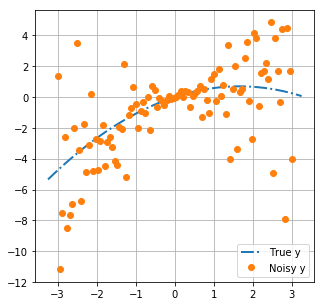

In [7]:
plt.figure(figsize=(5,5))
plt.plot(xplot, poly_func(xplot), '-.', lw=2)
plt.plot(x,y_data,'o')
plt.legend(('True y', 'Noisy y'), loc='best')
plt.grid('on')
plt.show()

### Make a function to calculate the sum of squared errors

This function calculates the sum of squared errors between observations and modeled equivalents. It is more general than `errfun` above which only works with the parabola function:

## $SSE=\Phi=\sum_{i=1}^{NPAR}\left(y_{i}-m\left(x_{i}\right)\right)^{2}$
where: 
 ## * $SSE$ is sum of squared errors
 ## * $y_i$ is the $i^{th}$ observation
 ## * $m\left(x_i\right)$ is the modeled equivalent to the $i^{th}$ observation
 
In vector notation, this is expressed as:
## $\Phi=\left(\mathbf{y}-\mathbf{m}\right)^{T}\left(\mathbf{y}-\mathbf{m}\right)$


In [8]:
def sum_squared_errors(y,m):
    y = np.atleast_1d(y)
    m = np.atleast_1d(m)
    sse = np.dot((y-m).T,(y-m))
    return sse

## Use $\Phi$ to evaluate the response surface

We can look at the response to change is parameters

In [9]:
a = np.linspace(polypars[0]-1.5,polypars[0]+1.5,20)
b = np.linspace(polypars[1]-5,polypars[1]+5,20)

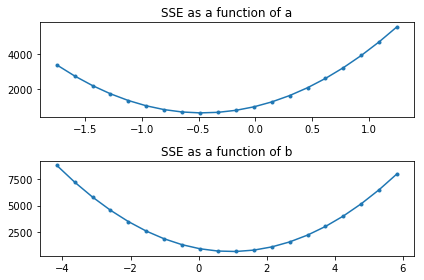

In [10]:
sse_a = []
for i in a:
    cfunc = np.poly1d([i,polypars[1],1])
    c_calculated = cfunc(x)
    sse_a.append(sum_squared_errors(y_data,c_calculated))
sse_b = []
for i in b:
    cfunc = np.poly1d([polypars[0],i,1])
    c_calculated = cfunc(x)
    sse_b.append(sum_squared_errors(y_data,c_calculated))
fig,ax=fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.plot(a,sse_a,'.-')
ax0.set_title('SSE as a function of a')
ax1.plot(b,sse_b,'.-')
ax1.set_title('SSE as a function of b')
plt.tight_layout()
plt.show()

In [11]:
A,B = np.meshgrid(a,b)
SSE_AB = np.zeros_like(A)
for i,junk in np.ndenumerate(SSE_AB):
    cfunc=np.poly1d([A[i], B[i], 0])
    SSE_AB[i] = sum_squared_errors(y_data,cfunc(x))

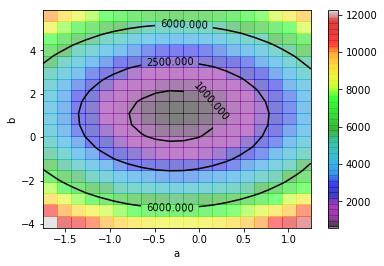

In [12]:
ax = plt.subplot(111)
p = ax.pcolor(A,B, SSE_AB,cmap="nipy_spectral",alpha=0.5)
plt.colorbar(p)

c = ax.contour(A,B, SSE_AB,levels=[500,1000,2500,6000],colors='k')
plt.clabel(c)
plt.xlabel('a')
plt.ylabel('b')
plt.show()

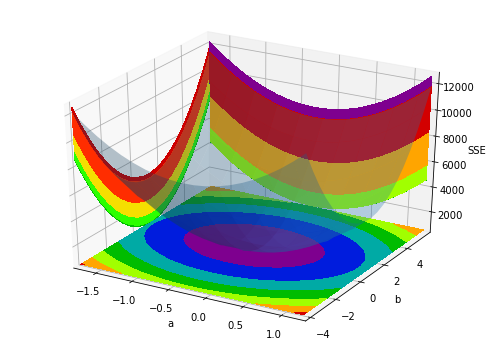

In [13]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(7,5))
ax = fig.gca(projection='3d')
ax.plot_surface(A,B,SSE_AB, rstride=2, cstride=2, alpha=0.3)
cset = ax.contourf(A,B,SSE_AB, zdir='x',  offset=np.min(a),cmap='nipy_spectral')
cset = ax.contourf(A,B,SSE_AB, zdir='y',  offset=np.max(b),cmap='nipy_spectral')
cset = ax.contourf(A,B,SSE_AB, zdir='z', offset=np.min(SSE_AB), cmap='nipy_spectral')
ax.set_xlabel('a')
ax.set_xlim(a[0],a[-1])
ax.set_ylabel('b')
ax.set_ylim(b[0],b[-1])
ax.set_zlabel('SSE')
ax.set_zlim(np.min(SSE_AB),np.max(SSE_AB))
plt.tight_layout()
import matplotlib.cm as cm
m = cm.ScalarMappable(cmap='nipy_spectral')
m.set_array(cset)
plt.show()

### Fit a polynomial function

Now fit a function assuming it will be a polynomial of the same degree (e.g. `best_degree`) as was used to generate the data

In [14]:
# fit the polynomial and then plot the resulting function
sol = spo.least_squares(errfun,[-2,2],args=(x,y_data))
y_fit_pars_best = [*sol.x,0]

### Look at the Jacobian matrix---gradients of parameters wrt. observations

For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^th$ observation with respect to the $j^th$ parameter is:  
## $\frac{\partial y_i}{\partial x_j}$
This can be approximated by finite differences as :  
## $\frac{\partial y_i}{\partial x_j}~\frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

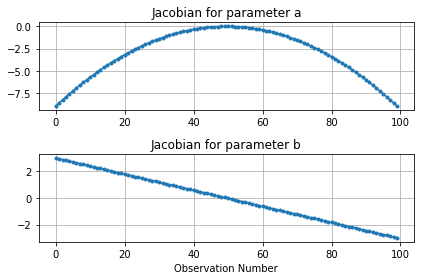

In [15]:
fig,ax=fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.plot(sol.jac[:,0],'.-')
ax0.grid('on')
ax0.set_title('Jacobian for parameter a')
ax1.plot(sol.jac[:,1],'.-')
plt.grid('on')
ax1.set_title('Jacobian for parameter b')
ax1.set_xlabel('Observation Number')
plt.tight_layout()
plt.show()

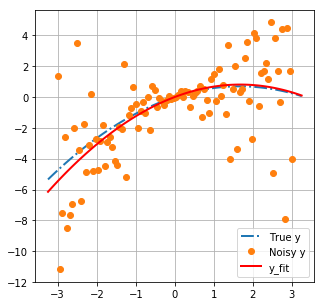

In [16]:
func_fit_best = np.poly1d(y_fit_pars_best)
plt.figure(figsize=(5,5))
xfitlox = np.linspace(x[0]-offset,x[-1]+offset,100)
plt.plot(xfitlox, poly_func(xfitlox), '-.', lw=2)
plt.plot(x,y_data,'o')
plt.grid('on')
plt.plot(xfitlox,func_fit_best(xfitlox), 'r-', lw=2)
plt.legend(('True y', 'Noisy y', 'y_fit'), loc='best')
plt.show()

### How did we do?

In [17]:
print('True parameters are:              a={0:.4f}, b={1:.4f}, c={2}'.format(*polypars))
print('The best-estimate parameters are: a={0:.4f}, b={1:.4f}, c={2}'.format(*y_fit_pars_best))

True parameters are:              a=-0.2503, b=0.8312, c=0.0
The best-estimate parameters are: a=-0.2864, b=0.9604, c=0


## Make a prediction

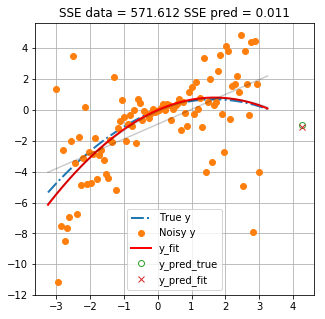

In [18]:
#set the x prediction beyond the end of the x range
range_x = (x[-1]-x[0])
x_pred = x[-1]+range_x*0.21
y_pred = poly_func(x_pred)
x_predlocations = np.linspace(x[0]-range_x*0.2, x_pred, 1000)
# plot the prediction
plt.figure(figsize=(5,5))
plt.plot(xfitlox, poly_func(xfitlox), '-.',lw=2)
plt.plot(x,y_data,'o')
plt.plot(xfitlox,func_fit_best(xfitlox), 'r-',lw=2)

datafit = sum_squared_errors(y_data,func_fit_best(x))
predfit = sum_squared_errors(func_fit_best(x_pred),poly_func(x_pred))

plt.plot(x_pred,y_pred, 'o', markerfacecolor='w')
plt.plot(x_pred,func_fit_best(x_pred), 'x')
plt.title('SSE data = {0:.3f} SSE pred = {1:.3f}'.format(datafit,predfit))
plt.legend(('True y', 'Noisy y', 'y_fit', 'y_pred_true', 'y_pred_fit'), loc='best')
plt.grid('on')

for i in range(best_degree):
    y_fit_pars = np.polyfit(x,y_data,i+1)
    func_fit = np.poly1d(y_fit_pars)
    plt.plot(xfitlox, func_fit(xfitlox), 'k-', alpha=0.2)
plt.show()

### Let's see what happens over a range of polynomial values
We can change the `offset` parameter to plot further outside the data range

We can also change the `extra_degrees` variable to plot curves of higher polynomial degree

In [33]:
x_predlocations = np.linspace(x[0]-range_x*0.2, x_pred, 1000)


In [49]:
offset=2
def plot_poly(cdegree):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(121)
    func_fit = np.poly1d(y_fit_pars_best)
    plt.plot(x_predlocations, poly_func(x_predlocations), '-.',lw=2)
    plt.plot(x,y_data,'o')
    plt.plot(x_predlocations,func_fit(x_predlocations), 'r-', linewidth=2)

    plt.legend(('True y', 'Noisy y', 'y_fit'), loc='best')
    offset=0
    xplot_fine = np.linspace(x[0]-offset,x[-1]+offset,1000)
    y_fit_pars = np.polyfit(x,y_data,cdegree)
    func_fit = np.poly1d(y_fit_pars)
    plt.plot(x_predlocations, func_fit(x_predlocations), 'k-')

    plt.plot(x_pred,poly_func(x_pred), 'o', markerfacecolor='w')
    plt.title('Free Scale')
    plt.grid('on')
    
    # 
    ax = fig.add_subplot(122)
    func_fit = np.poly1d(y_fit_pars_best)
    plt.plot(x_predlocations, poly_func(x_predlocations), '-.',lw=2)
    plt.plot(x,y_data,'o')
    plt.plot(x_predlocations,func_fit(x_predlocations), 'r-', linewidth=2)

    plt.legend(('True y', 'Noisy y', 'y_fit'), loc='best')
    offset=0
    xplot_fine = np.linspace(x[0]-offset,x[-1]+offset,1000)
    y_fit_pars = np.polyfit(x,y_data,cdegree)
    func_fit = np.poly1d(y_fit_pars)
    plt.plot(xplot_fine, func_fit(xplot_fine), 'k-')

    plt.plot(x_pred,poly_func(x_pred), 'o', markerfacecolor='w')
    plt.grid('on')
    plt.title('Restricted Scale')
    plt.show()

In [57]:
widgets.interact(plot_poly, cdegree=widgets.IntSlider(min=1,max=30,step=1,value=3));

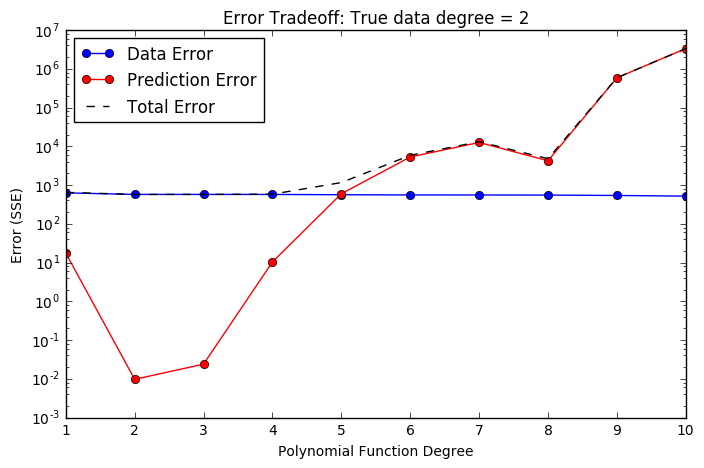

In [33]:
plt.figure(figsize=(8,5))
all_datafit = np.array(all_datafit)
all_predfit = np.array(all_predfit)
plt.plot(degree_range,all_datafit, 'bo-')
plt.plot(degree_range,all_predfit, 'ro-')
plt.plot(degree_range, all_predfit + all_datafit, 'k--')
plt.yscale('log')
plt.xlabel('Polynomial Function Degree')
plt.ylabel('Error (SSE)')
plt.legend(('Data Error', 'Prediction Error', 'Total Error'), loc='best')
plt.title('Error Tradeoff: True data degree = {0}'.format(best_degree))

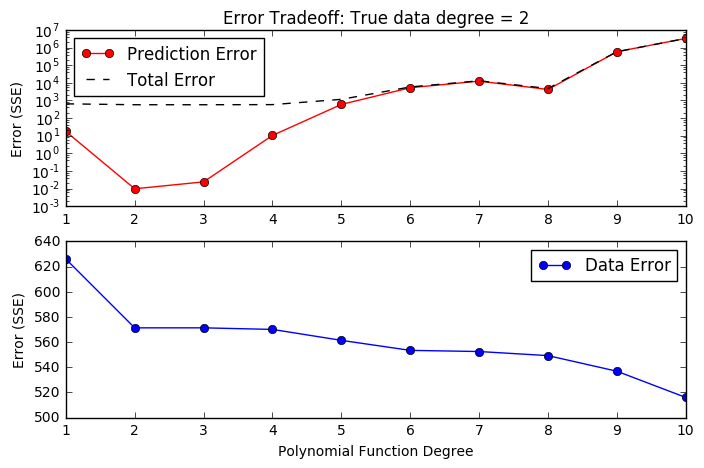

In [34]:
fig,(ax0,ax1) = plt.subplots(nrows=2,figsize=(8,5))
ax0.set_title('Error Tradeoff: True data degree = {0}'.format(best_degree))
ax0.plot(degree_range,all_predfit, 'ro-')
ax0.plot(degree_range, all_predfit + all_datafit, 'k--')
ax0.set_yscale('log')
ax0.set_ylabel('Error (SSE)')
ax0.legend(('Prediction Error', 'Total Error'), loc='best')
ax1.plot(degree_range,all_datafit, 'bo-')

plt.xlabel('Polynomial Function Degree')
plt.ylabel('Error (SSE)')
plt.legend(['Data Error'], loc='best')
